In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
""" 
Read the data on Ferility rates per woman and possible features that influence fertility 
Data is downloaded from the WB web page: https://data.worldbank.org/indicator
and is in form of csv file with different countries and regions as rows and years as columns.
"""

def load_data():
    
    FertilityRate = pd.read_csv("FertilityRate.csv")
    Mortality_Under5 = pd.read_csv("SurvivolTo65_Female.csv")
    Survival_To65_F = pd.read_csv("MortalityRate_Under5Years.csv")
    LifeExp_F = pd.read_csv("LifeExp_Female.csv")
    LifeExp_M = pd.read_csv("LifeExp_Male.csv")
    Literacy_F = pd.read_csv("LiteracyRate_FemaleAdult.csv")
    Literacy_M = pd.read_csv("LiteracyRate_MaleAdult.csv")    
    GDP = pd.read_csv("GDP_PerCapita_ConstantDollar.csv")
    Urban = pd.read_csv("Urban_residence.csv")   
    
    Fertility = FertilityRate.loc[4:, FertilityRate.columns[6:62]].values
    Mortality_Under5 = Mortality_Under5.loc[4:, Mortality_Under5.columns[6:62]].values
    Survival_To65_F = Survival_To65_F.loc[4:, Survival_To65_F.columns[6:62]].values
    LE_F = LifeExp_F.loc[4:, LifeExp_F.columns[6:62]].values
    LE_M = LifeExp_M.loc[4:, LifeExp_M.columns[6:62]].values
    Literacy_F = Literacy_F.loc[4:, Literacy_F.columns[6:62]].values
    Literacy_M = Literacy_M.loc[4:, Literacy_M.columns[6:62]].values
    GDP = GDP.loc[4:, GDP.columns[6:62]].values
    Urban = Urban.loc[4:, Urban.columns[6:62]].values
    
    Countries = FertilityRate['Data Source'][4:].values.tolist()
    Years = FertilityRate.loc[3, FertilityRate.columns[6:62]].values.astype(int)
    
    return Years, Countries, Fertility, Mortality_Under5, Survival_To65_F, LE_F, LE_M, Literacy_F, Literacy_M, GDP, Urban

In [3]:
Years, Countries, Fertility, Mortality_Under5, Survival_To65_F, LE_F, LE_M, Literacy_F, Literacy_M, GDP, Urban = load_data()

Let's make a full model with all the variables inclueded as predictors.

In [4]:
All_variable = np.array([Fertility, Mortality_Under5, Survival_To65_F, LE_F, LE_M, Literacy_F, Literacy_M, GDP, Urban]).T
not_empty = ~np.isnan(All_variable)

Clean_data = not_empty[:,:, 0]
for i in range(not_empty.shape[2]-1):
    Clean_data = np.logical_and(Clean_data, not_empty[:,:,i+1]) 

All_variable = All_variable[Clean_data, :]

In [5]:
Y = All_variable[:,0]
Y = np.reshape(Y, (Y.size,1))   
X = All_variable[:,1:]
#One has to add constant by hand for OLS
X = sm.add_constant(X)

map = {"x1": 'Mortality_Under_Age5', "x2": 'Survival_To65_F', "x3": 'LifeExpectancy_F', 
       "x4": 'LifeExpectancy_M', "x5": 'Literacy_F', "x6": 'Literacy_M', "x7": 'GDP', "x8": 'UrbanPopulation'}

X[:,1] = np.divide(X[:,1],1000) #Mortality rate is per 1,000 live births
#Survaval to age 65, Literacy and Urban residence are in percentages
X[:,[2,5,6,8]]= np.divide(X[:,[2,5,6,8]], 100)

#Life expectancy and GDP are rescaled with StandardScaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X[:,[3,4,7]] = sc.fit_transform(X[:,[3,4,7]])   

Let's check the results of the full model.

In [6]:
Model = sm.OLS(Y, X).fit()
print(Model.summary())
map

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     1165.
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:02:27   Log-Likelihood:                -1691.8
No. Observations:                1826   AIC:                             3402.
Df Residuals:                    1817   BIC:                             3451.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3493      0.714      7.487      0.0

{'x1': 'Mortality_Under_Age5',
 'x2': 'Survival_To65_F',
 'x3': 'LifeExpectancy_F',
 'x4': 'LifeExpectancy_M',
 'x5': 'Literacy_F',
 'x6': 'Literacy_M',
 'x7': 'GDP',
 'x8': 'UrbanPopulation'}

What we see is that mortality under age of 5, survival of females until age of 65 as well as GDP of the country 
are not significant predictors for the female ferility rate. 
However, we didn't cheked for correlation of the featues as this point.

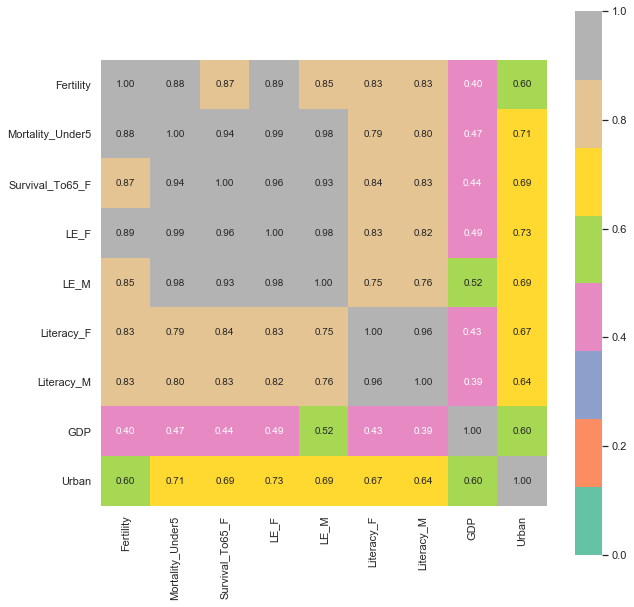

In [7]:
corrmat = np.corrcoef(All_variable.T)

plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
names = ['Fertility', 'Mortality_Under5', 'Survival_To65_F', 'LE_F', 'LE_M', 'Literacy_F', 'Literacy_M', 'GDP', 'Urban']
sns.heatmap(np.abs(corrmat), cbar=True, cmap='Set2', annot=True, vmin=0, vmax =1, square=True, fmt='.2f', annot_kws={'size': 10},
                yticklabels = names, xticklabels = names)
plt.show()

We see that Fetility is highly correlated with all features. The lowest correlation is for GDP (r = -0.4). 

The reason for the relative low correlation with GDP lies in exponential dependency. For low GDP we have a huge variety of ferility rates, but we do see a trend that very rich countries have ferility per woman under 3 children.

Text(0, 0.5, 'Fertility per woman')

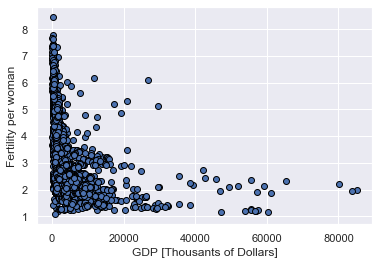

In [8]:
fig = plt.figure()
plt.tight_layout()
plt.scatter(All_variable[:,7], All_variable[:,0], edgecolors = 'black')
plt.xlabel("GDP [Thousants of Dollars]")
plt.ylabel("Fertility per woman")

The problem is that many covariate are highly correlated, like Life Expectancy of a female and male and Literacy rates among female and male. 
The first task is to see if life expectancy of a female, life expectancy of a male of survival to age 65 of a female play more significant role taken one by one.

In [9]:
Model = sm.OLS(Y, np.array([X[:,0], X[:,3]]).T).fit()
print("R^2 for Life expectancy of females as predictor", Model.rsquared.astype('float32'))
Model = sm.OLS(Y, np.array([X[:,0], X[:,4]]).T).fit()
print("R^2 for Life expectancy of males as predictor", Model.rsquared.astype('float32'))
Model = sm.OLS(Y, np.array([X[:,0], X[:,2]]).T).fit()
print("R^2 for survavol of female until age 65 as predictor", Model.rsquared.astype('float32'))
Model = sm.OLS(Y, np.array([X[:,0], X[:,1]]).T).fit()
print("R^2 for mortality of childer under age of 5 as predictor", Model.rsquared.astype('float32'))

R^2 for Life expectancy of females as predictor 0.7959537
R^2 for Life expectancy of males as predictor 0.7224647
R^2 for survavol of female until age 65 as predictor 0.74856853
R^2 for mortality of childer under age of 5 as predictor 0.77325195


In [10]:
Model = sm.OLS(Y, np.array([X[:,0], X[:,5]]).T).fit()
print("R^2 for Literacy of females as predictor", Model.rsquared.astype('float32'))
Model = sm.OLS(Y, np.array([X[:,0], X[:,6]]).T).fit()
print("R^2 for Literacy of males as predictor", Model.rsquared.astype('float32'))

R^2 for Literacy of females as predictor 0.68301356
R^2 for Literacy of males as predictor 0.68197584


Therefore we bouild a new model with only life expectancy of a female, literacy rate and urban population as predictors.

In [11]:
All_variable_selected = np.array([Fertility, LE_F, Literacy_F, Urban]).T
not_empty = ~np.isnan(All_variable_selected)

Clean_data = not_empty[:,:, 0]
for i in range(not_empty.shape[2]-1):
    Clean_data = np.logical_and(Clean_data, not_empty[:,:,i+1]) 

All_variable_selected = All_variable_selected[Clean_data, :]

In [12]:
Y = All_variable_selected[:,0]
Y = np.reshape(Y, (Y.size,1))   
X = All_variable_selected[:,1:]
X = sm.add_constant(X)

map = {"x1": 'LifeExpectancy_Female', "x2": 'Literacy_Female', "x3": 'UrbanPopulation'}

#Literacy and Urban residence are in percentages
X[:,[2,3]]= np.divide(X[:,[2,3]], 100)

#Life expectancy and GDP are rescaled with StandardScaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X[:,[1]] = sc.fit_transform(X[:,[1]])   
#One has to add constant by hand for OLS

Model = sm.OLS(Y, X).fit()
print(Model.summary())
map

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     4266.
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:02:33   Log-Likelihood:                -2145.4
No. Observations:                2314   AIC:                             4299.
Df Residuals:                    2310   BIC:                             4322.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3132      0.079     54.382      0.0

{'x1': 'LifeExpectancy_Female',
 'x2': 'Literacy_Female',
 'x3': 'UrbanPopulation'}

Our linear model explains 84.7% variance of the ferility data which is quite a lot. However, let's check if the linear model really is the best choice.

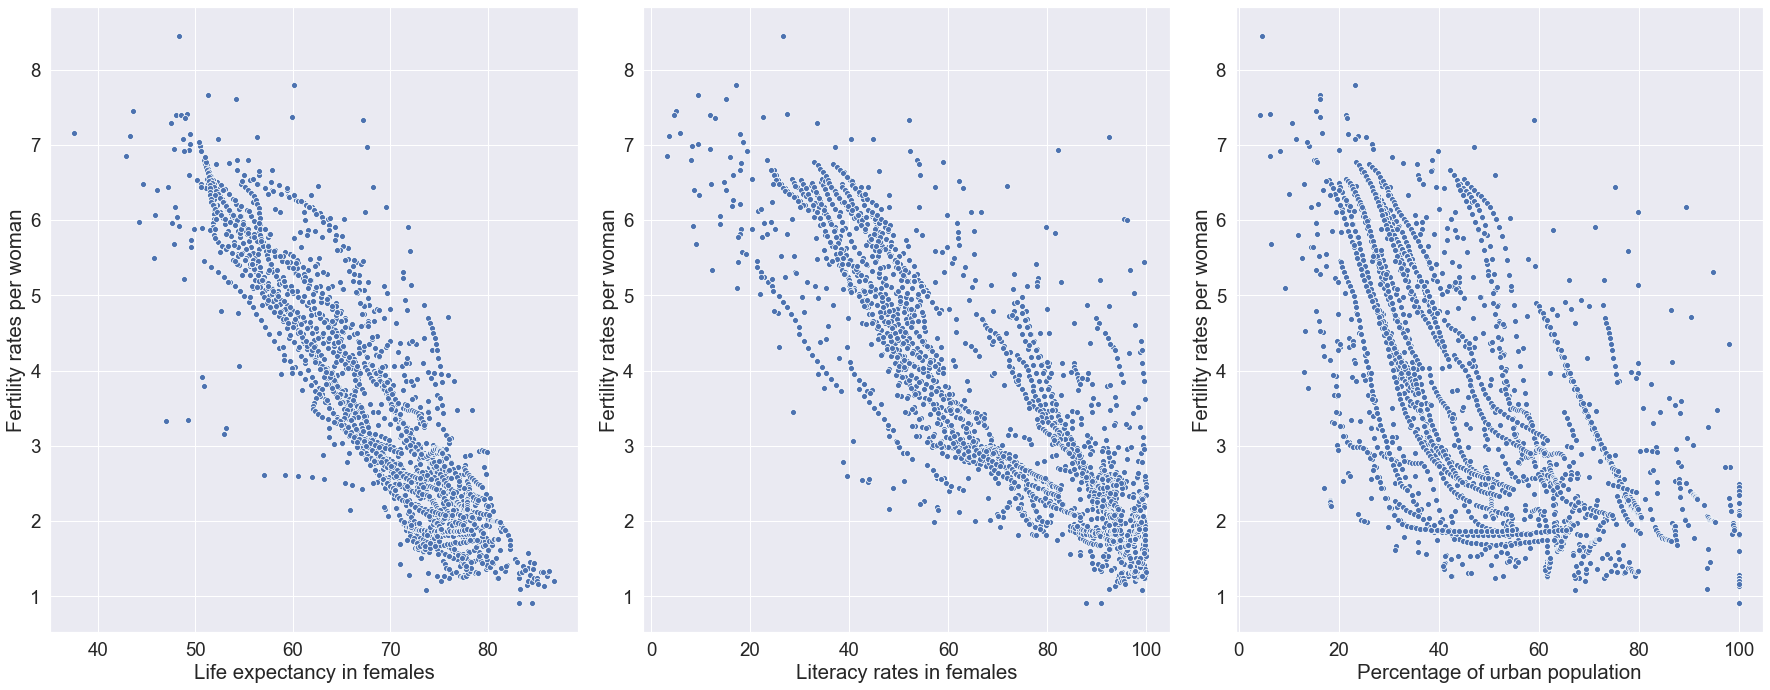

In [17]:
df = pd.DataFrame(All_variable_selected,  columns=["Fertility rates per woman", "Life expectancy in females", "Literacy rates in females", "Percentage of urban population"])
plt.figure(figsize = (25,10))
sns.set(font_scale = 1.7)
plt.subplot(131)
sns.scatterplot(x = "Life expectancy in females", y = "Fertility rates per woman", data = df)
plt.subplot(132)
sns.scatterplot(x = "Literacy rates in females", y = "Fertility rates per woman", data = df)
plt.subplot(133)
sns.scatterplot(x = "Percentage of urban population", y = "Fertility rates per woman", data = df)
plt.tight_layout()

We see that fertility of a woman does not depend linearly on the percentage of urban populatio and the data is quite spars. However, we keep this feature because model with percentage of urban resiedence as covariate has lower BIC (4321) than the model without it (4583).

Is female ferility really linerly dependent on her life expectancy?

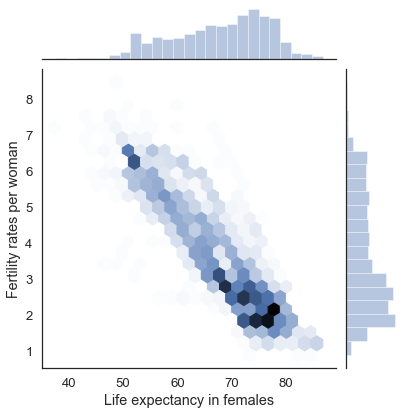

In [18]:
AllData_LifeExpectancy = np.array([Fertility, LE_F]).T
empty = np.logical_and(~np.isnan(AllData_LifeExpectancy[:,:,0]), ~np.isnan(AllData_LifeExpectancy[:,:,1]))
AllData_LifeExpectancy = AllData_LifeExpectancy[empty, :]

df2 = pd.DataFrame(AllData_LifeExpectancy, columns = ["Fertility rates per woman", "Life expectancy in females"])

sns.set(font_scale = 1.2)
with sns.axes_style('white'):
    sns.jointplot("Life expectancy in females", "Fertility rates per woman", data=df, kind='hex')
    

Plot for 9,256 data points which are not nan for all covariate reveals linear behaviour. 

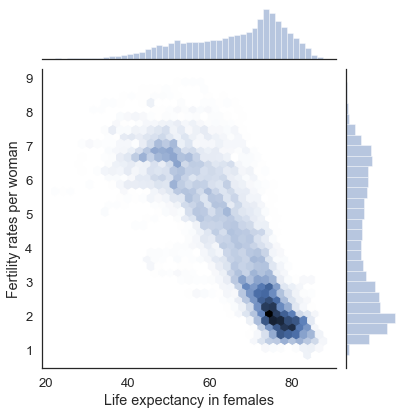

In [19]:
with sns.axes_style('white'):
    sns.jointplot("Life expectancy in females", "Fertility rates per woman", data=df2, kind='hex')

Plot for 13,498 of data points which are not nan for life expectancy reveals stauration of the data for very high and very low life expectancies. 

Since this function looks more like tanh one could also test a model with only hyperbolic tangens of the female life expectancy as a predictor for the female fertility. If you are interested, check Female_Life_Expectancy notebook file. 